# Analysis of Chest X-Ray images

Neural networks have revolutionised image processing in several different domains. Among these is the field of medical imaging. In the following notebook, we will get some hands-on experience in working with Chest X-Ray (CXR) images.

The objective of this exercise is to identify images where an "effusion" is present. This is a classification problem, where we will be dealing with two classes - 'effusion' and 'nofinding'. Here, the latter represents a "normal" X-ray image.

This same methodology can be used to spot various other illnesses that can be detected via a chest x-ray. For the scope of this demonstration, we will specifically deal with "effusion".

### Imports and helper methods

In [150]:
import six
from keras.models import Model
from keras.layers import (
    Input,
    Activation,
    Dense,
    Flatten
)
from keras.layers.convolutional import (
    Conv2D,
    MaxPooling2D,
    AveragePooling2D
)
from keras.layers.merge import add
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from keras import backend as K
from keras.callbacks import TensorBoard

In [135]:
def _bn_relu(input):
    """Helper to build a BN -> relu block
    """
    norm = BatchNormalization(axis=CHANNEL_AXIS)(input)
    return Activation("relu")(norm)


def _conv_bn_relu(**conv_params):
    """Helper to build a conv -> BN -> relu block
    """
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1))
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1.e-4))

    def f(input):
        conv = Conv2D(filters=filters, kernel_size=kernel_size,
                      strides=strides, padding=padding,
                      kernel_initializer=kernel_initializer,
                      kernel_regularizer=kernel_regularizer)(input)
        return _bn_relu(conv)

    return f


def _bn_relu_conv(**conv_params):
    """Helper to build a BN -> relu -> conv block.
    This is an improved scheme proposed in http://arxiv.org/pdf/1603.05027v2.pdf
    """
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1))
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1.e-4))

    def f(input):
        activation = _bn_relu(input)
        return Conv2D(filters=filters, kernel_size=kernel_size,
                      strides=strides, padding=padding,
                      kernel_initializer=kernel_initializer,
                      kernel_regularizer=kernel_regularizer)(activation)

    return f


def _shortcut(input, residual):
    """Adds a shortcut between input and residual block and merges them with "sum"
    """
    # Expand channels of shortcut to match residual.
    # Stride appropriately to match residual (width, height)
    # Should be int if network architecture is correctly configured.
    input_shape = K.int_shape(input)
    residual_shape = K.int_shape(residual)
    stride_width = int(round(input_shape[ROW_AXIS] / residual_shape[ROW_AXIS]))
    stride_height = int(round(input_shape[COL_AXIS] / residual_shape[COL_AXIS]))
    equal_channels = input_shape[CHANNEL_AXIS] == residual_shape[CHANNEL_AXIS]

    shortcut = input
    # 1 X 1 conv if shape is different. Else identity.
    if stride_width > 1 or stride_height > 1 or not equal_channels:
        shortcut = Conv2D(filters=residual_shape[CHANNEL_AXIS],
                          kernel_size=(1, 1),
                          strides=(stride_width, stride_height),
                          padding="valid",
                          kernel_initializer="he_normal",
                          kernel_regularizer=l2(0.0001))(input)

    return add([shortcut, residual])


def _residual_block(block_function, filters, repetitions, is_first_layer=False):
    """Builds a residual block with repeating bottleneck blocks.
    """
    def f(input):
        for i in range(repetitions):
            init_strides = (1, 1)
            if i == 0 and not is_first_layer:
                init_strides = (2, 2)
            input = block_function(filters=filters, init_strides=init_strides,
                                   is_first_block_of_first_layer=(is_first_layer and i == 0))(input)
        return input

    return f


def basic_block(filters, init_strides=(1, 1), is_first_block_of_first_layer=False):
    """Basic 3 X 3 convolution blocks for use on resnets with layers <= 34.
    Follows improved proposed scheme in http://arxiv.org/pdf/1603.05027v2.pdf
    """
    def f(input):

        if is_first_block_of_first_layer:
            # don't repeat bn->relu since we just did bn->relu->maxpool
            conv1 = Conv2D(filters=filters, kernel_size=(3, 3),
                           strides=init_strides,
                           padding="same",
                           kernel_initializer="he_normal",
                           kernel_regularizer=l2(1e-4))(input)
        else:
            conv1 = _bn_relu_conv(filters=filters, kernel_size=(3, 3),
                                  strides=init_strides)(input)

        residual = _bn_relu_conv(filters=filters, kernel_size=(3, 3))(conv1)
        return _shortcut(input, residual)

    return f


def bottleneck(filters, init_strides=(1, 1), is_first_block_of_first_layer=False):
    """Bottleneck architecture for > 34 layer resnet.
    Follows improved proposed scheme in http://arxiv.org/pdf/1603.05027v2.pdf
    Returns:
        A final conv layer of filters * 4
    """
    def f(input):

        if is_first_block_of_first_layer:
            # don't repeat bn->relu since we just did bn->relu->maxpool
            conv_1_1 = Conv2D(filters=filters, kernel_size=(1, 1),
                              strides=init_strides,
                              padding="same",
                              kernel_initializer="he_normal",
                              kernel_regularizer=l2(1e-4))(input)
        else:
            conv_1_1 = _bn_relu_conv(filters=filters, kernel_size=(1, 1),
                                     strides=init_strides)(input)

        conv_3_3 = _bn_relu_conv(filters=filters, kernel_size=(3, 3))(conv_1_1)
        residual = _bn_relu_conv(filters=filters * 4, kernel_size=(1, 1))(conv_3_3)
        return _shortcut(input, residual)

    return f


def _handle_dim_ordering():
    global ROW_AXIS
    global COL_AXIS
    global CHANNEL_AXIS
    if K.image_dim_ordering() == 'tf':
        ROW_AXIS = 1
        COL_AXIS = 2
        CHANNEL_AXIS = 3
    else:
        CHANNEL_AXIS = 1
        ROW_AXIS = 2
        COL_AXIS = 3


def _get_block(identifier):
    if isinstance(identifier, six.string_types):
        res = globals().get(identifier)
        if not res:
            raise ValueError('Invalid {}'.format(identifier))
        return res
    return identifier


class ResnetBuilder(object):
    @staticmethod
    def build(input_shape, num_outputs, block_fn, repetitions):
        """Builds a custom ResNet like architecture.
        Args:
            input_shape: The input shape in the form (nb_channels, nb_rows, nb_cols)
            num_outputs: The number of outputs at final softmax layer
            block_fn: The block function to use. This is either `basic_block` or `bottleneck`.
                The original paper used basic_block for layers < 50
            repetitions: Number of repetitions of various block units.
                At each block unit, the number of filters are doubled and the input size is halved
        Returns:
            The keras `Model`.
        """
        _handle_dim_ordering()
        if len(input_shape) != 3:
            raise Exception("Input shape should be a tuple (nb_channels, nb_rows, nb_cols)")

        # Permute dimension order if necessary
        if K.image_dim_ordering() == 'tf':
            input_shape = (input_shape[1], input_shape[2], input_shape[0])

        # Load function from str if needed.
        block_fn = _get_block(block_fn)

        input = Input(shape=input_shape)
        conv1 = _conv_bn_relu(filters=64, kernel_size=(7, 7), strides=(2, 2))(input)
        pool1 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding="same")(conv1)

        block = pool1
        filters = 64
        for i, r in enumerate(repetitions):
            block = _residual_block(block_fn, filters=filters, repetitions=r, is_first_layer=(i == 0))(block)
            filters *= 2

        # Last activation
        block = _bn_relu(block)

        # Classifier block
        block_shape = K.int_shape(block)
        pool2 = AveragePooling2D(pool_size=(block_shape[ROW_AXIS], block_shape[COL_AXIS]),
                                 strides=(1, 1))(block)
        flatten1 = Flatten()(pool2)
        dense = Dense(units=num_outputs, kernel_initializer="he_normal",
                      activation="softmax")(flatten1)

        model = Model(inputs=input, outputs=dense)
        return model

    @staticmethod
    def build_resnet_18(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, basic_block, [2, 2, 2, 2])

    @staticmethod
    def build_resnet_34(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, basic_block, [3, 4, 6, 3])

    @staticmethod
    def build_resnet_50(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, bottleneck, [3, 4, 6, 3])

    @staticmethod
    def build_resnet_101(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, bottleneck, [3, 4, 23, 3])

    @staticmethod
    def build_resnet_152(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, bottleneck, [3, 8, 36, 3])

# Analysis of Chest X-Ray images

Neural networks have revolutionised image processing in several different domains. Among these is the field of medical imaging. In the following notebook, we will get some hands-on experience in working with Chest X-Ray (CXR) images.

The objective of this exercise is to identify images where an "effusion" is present. This is a classification problem, where we will be dealing with two classes - 'effusion' and 'nofinding'. Here, the latter represents a "normal" X-ray image.

This same methodology can be used to spot various other illnesses that can be detected via a chest x-ray. For the scope of this demonstration, we will specifically deal with "effusion".

## 1. Data Pre-processing

Our data is in the form of grayscale (black and white) images of chest x-rays. To perform our classification task effectively, we need to perform some pre-processing of the data.

First, we load all the relevant libraries.

In [136]:
import keras
from skimage import io
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

import warnings
warnings.simplefilter('ignore')

UsageError: Line magic function `%` not found.


Point a variable to the path where the data resides. Note that to use the code below you will need to move the folders effusion/ and nofinding/ into one common folder. You can do something like this:

```
mkdir CXR_Data
move effusion CXR_Data
move nofinding CXR_Data
```

In [137]:
DATASET_PATH = 'CXR_data'

# There are two classes of images that we will deal with
disease_cls = ['effusion', 'nofinding']

Next, we read the "effusion" and "nofinding" images.

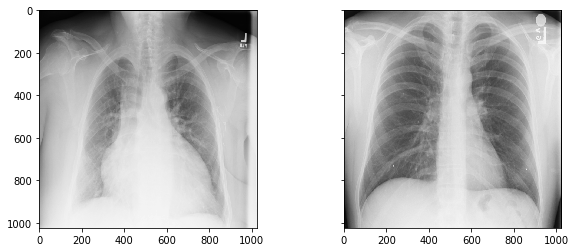

In [138]:
effusion_path = os.path.join(DATASET_PATH, disease_cls[0], '*')
effusion_path_list = glob.glob(effusion_path)
effusion = io.imread(effusion_path_list[1])

normal_path = os.path.join(DATASET_PATH, disease_cls[1], '*')
normal_path_list = glob.glob(normal_path)
normal = io.imread(normal_path_list[1])

f, axes = plt.subplots(1, 2, sharey=True)
f.set_figwidth(10)
    
axes[0].imshow(effusion, cmap='gray')
axes[1].imshow(normal, cmap='gray')

In [139]:
effusion.shape

(1024, 1024)

In [140]:
normal.shape

(1024, 1024)

#### Images are really high resolution(1024,1024) and needs to be reduced to smaller size ,  moreover these images have 2 channel

### Data Augmentation ###

Now that we have read the images, the next step is data augmentation. We use the concept of a "data generator" that you learnt in the last section.

In [141]:
from skimage.transform import rescale
from keras.preprocessing.image import ImageDataGenerator

In [142]:
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=10,
    width_shift_range=0, # cannot shift X-rays horizontally 
    height_shift_range=0, # cannot shift X-rays horizontally
    vertical_flip=False,) # cannot flip X_ray vertically hence it is false

1. Vertical flip needs to be set as 'False'. This is because CXR images have a natural orientation - up to down. 
2. We cannot (i.e. should not) do a centre crop for CXR images, as the anomaly can be in an area outside the cropped portion of the image.

In [182]:
def preprocess_img(img, mode):
    img = (img - img.min())/(img.max() - img.min())
    
    # rescaling only depends upon the problem, if problem is to detect cancer then high resolutoin needs to
    # be used as scaling startregy needs to be changed
    # reduce it to 1/4th size
    img = rescale(img, 0.25, multichannel=True, mode='constant') 
    
    if mode == 'train':
        if np.random.randn() > 0: # randomizing the transformation
            img = datagen.random_transform(img)
            
    return img

1. Since the CXR images are not "natural images", we do not use the "divide by 255" strategy. Instead, we take the max-min approach to normalisation. Since we do not know for sure that the range of each pixel is 0-255, you normalise using the min-max values.
2. In the conditional statement 'if mode == train', use a random number generator so that only a fraction of the images get transformed (rather than all of them). 

## 2. Model building

We will be using a Resnet in this (you learnt about Resnets previously). 

For this to work, the script that defines the resnet model (resnet.py) should reside in the same folder as this notebook

In [144]:
import resnet
import numpy as np
import keras

In [145]:
img_channels = 1 # only one channel black/white

img_rows = 256   
img_cols = 256

nb_classes = 2  # effusion & nofindings 

In [146]:
import numpy as np
import keras

class AugmentedDataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, mode='train', ablation=None, disease_cls = ['nofinding', 'effusion'], 
                 batch_size=32, dim=(256, 256), n_channels=1, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = {}
        self.list_IDs = []
        self.mode = mode
        
        'Idea is to get 80% of the image from each class and use them to train model'
        for i, cls in enumerate(disease_cls):
            paths = glob.glob(os.path.join(DATASET_PATH, cls, '*'))
            brk_point = int(len(paths)*0.8) # picking up 80% of the images
            if self.mode == 'train':
                paths = paths[:brk_point]
            else:
                paths = paths[brk_point:]
            if ablation is not None:
                paths = paths[:int(len(paths)*ablation/100)]
            self.list_IDs += paths
            self.labels.update({p:i for p in paths})
        
            
        self.n_channels = n_channels
        self.n_classes = len(disease_cls)
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'

        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)
        
        delete_rows = []

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            img = io.imread(ID)
            img = img[:, :, np.newaxis]
            if img.shape == (1024, 1024,1):
                img = preprocess_img(img, self.mode)
                X[i,] = img
                y[i] = self.labels[ID]
            else:
                delete_rows.append(i)
                continue
                
        X = np.delete(X, delete_rows, axis=0)
        y = np.delete(y, delete_rows, axis=0)
        
        return X, keras.utils.to_categorical(y, num_classes=self.n_classes)

In [158]:
def getLogger(name):
    # Create a TensorBoard logger
    logger = TensorBoard(log_dir='logs/{}'.format(name),write_graph=False,histogram_freq=0)
    return logger

## 3. Ablation Run

An ablation run is when you systematically modify certain parts of the input, in order to observe the equivalent change in the input.

In [159]:
model = ResnetBuilder.build_resnet_18((img_channels, img_rows, img_cols), nb_classes)
model.compile(loss='categorical_crossentropy',optimizer='SGD',metrics=['accuracy'])

training_generator = AugmentedDataGenerator('train', ablation=1000, batch_size=256)
validation_generator = AugmentedDataGenerator('val', ablation=1000, batch_size=256)

model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    epochs=1,
                    callbacks=[getLogger("resnet_18_ab_1000_epoc_1")])

Epoch 1/1
3/3 [==============================] - 182s 61s/step - loss: 1.1259 - acc: 0.8953


In [160]:
model = ResnetBuilder.build_resnet_18((img_channels, img_rows, img_cols), nb_classes)
model.compile(loss='categorical_crossentropy',optimizer='SGD',metrics=['accuracy'])

training_generator = AugmentedDataGenerator('train', ablation=5)
validation_generator = AugmentedDataGenerator('val', ablation=5)

model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    epochs=1,
                    callbacks=[getLogger("resnet_18_ab_5_epoc_1")])

Epoch 1/1
1/1 [==============================] - 13s 13s/step - loss: 1.1829 - acc: 0.9032


In [161]:
model = ResnetBuilder.build_resnet_18((img_channels, img_rows, img_cols), nb_classes)
model.compile(loss='categorical_crossentropy',optimizer='SGD', metrics=['accuracy'])

training_generator = AugmentedDataGenerator('train', ablation=5)
validation_generator = AugmentedDataGenerator('validation', ablation=5)

model.fit_generator(generator=training_generator,
                    validation_data=None,
                    epochs=5,
                    callbacks=[getLogger("resnet_18_ab_5_epoc_5_SGD")])

Epoch 1/5
1/1 [==============================] - 14s 14s/step - loss: 1.7602 - acc: 0.1000
Epoch 2/5
1/1 [==============================] - 5s 5s/step - loss: 1.3465 - acc: 0.8438
Epoch 3/5
1/1 [==============================] - 5s 5s/step - loss: 1.1968 - acc: 0.9032
Epoch 4/5
1/1 [==============================] - 5s 5s/step - loss: 1.1330 - acc: 0.9032
Epoch 5/5
1/1 [==============================] - 5s 5s/step - loss: 1.0942 - acc: 0.9000


In [162]:
model = ResnetBuilder.build_resnet_18((img_channels, img_rows, img_cols), nb_classes)
model.compile(loss='categorical_crossentropy',optimizer='Adam', metrics=['accuracy'])

training_generator = AugmentedDataGenerator('train', ablation=5)
validation_generator = AugmentedDataGenerator('validation', ablation=5)

model.fit_generator(generator=training_generator,
                    validation_data=None,
                    epochs=5,
                    callbacks=[getLogger("resnet_18_ab_5_epoc_5_Adam")])

Epoch 1/5
1/1 [==============================] - 14s 14s/step - loss: 1.6949 - acc: 0.0968
Epoch 2/5
1/1 [==============================] - 5s 5s/step - loss: 1.6411 - acc: 0.5000
Epoch 3/5
1/1 [==============================] - 5s 5s/step - loss: 1.1881 - acc: 0.8065
Epoch 4/5
1/1 [==============================] - 5s 5s/step - loss: 1.0577 - acc: 0.9032
Epoch 5/5
1/1 [==============================] - 5s 5s/step - loss: 1.0141 - acc: 0.9032


- The data class is highly imbalanced. The ratio of 'effusion' vs 'nofinding' is almost 10 (107/1000). 
- As most of the data belongs to only one class, simply training in this scenario will not work as the model will learn mostly learn and classify most of the data as 'nofinding' resulting in high accuracy.  
- If we notice, around 90 per cent (1000/1107) of the data is 'nofinding' and if it classifies all the data as same, the accuracy will be 90 per cent which is close to 87 per cent accuracy which we have got. 
- So, the objective to correctly classify the 'effusion' is not fulfilled. 

<b>The high accuracy clearly misleads us and therefore we will use AUC to validate the result. </b>

In [163]:
from sklearn.metrics import roc_auc_score
from keras import optimizers
from keras.callbacks import *

class roc_callback(Callback):
    
    def on_train_begin(self, logs={}):
        logs['val_auc'] = 0

    def on_epoch_end(self, epoch, logs={}):
        y_p = []
        y_v = []
        for i in range(len(validation_generator)):
            x_val, y_val = validation_generator[i]
            y_pred = self.model.predict(x_val)
            y_p.append(y_pred)
            y_v.append(y_val)
        y_p = np.concatenate(y_p)
        y_v = np.concatenate(y_v)
        roc_auc = roc_auc_score(y_v, y_p)
        print ('\nVal AUC for epoch{}: {}'.format(epoch, roc_auc))
        logs['val_auc'] = roc_auc

In [165]:
model = ResnetBuilder.build_resnet_18((img_channels, img_rows, img_cols), nb_classes)
model.compile(loss='categorical_crossentropy',optimizer='SGD',metrics=['accuracy'])

training_generator = AugmentedDataGenerator('train', ablation=20)
validation_generator = AugmentedDataGenerator('validation', ablation=20)

auc_logger = roc_callback()

model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    epochs=5, callbacks=[auc_logger])

Epoch 1/5
5/5 [==============================] - 72s 14s/step - loss: 1.2710 - acc: 0.7612 - val_loss: 1.1382 - val_acc: 0.8750

Val AUC for epoch0: 0.5632183908045977
Epoch 2/5
5/5 [==============================] - 29s 6s/step - loss: 1.0802 - acc: 0.8977 - val_loss: 1.0620 - val_acc: 0.9062

Val AUC for epoch1: 0.6833333333333333
Epoch 3/5
5/5 [==============================] - 31s 6s/step - loss: 1.0837 - acc: 0.8898 - val_loss: 0.9937 - val_acc: 0.9375

Val AUC for epoch2: 0.4942528735632184
Epoch 4/5
5/5 [==============================] - 32s 6s/step - loss: 1.0542 - acc: 0.9034 - val_loss: 1.0589 - val_acc: 0.9062

Val AUC for epoch3: 0.1724137931034483
Epoch 5/5
5/5 [==============================] - 31s 6s/step - loss: 1.0570 - acc: 0.8969 - val_loss: 1.0857 - val_acc: 0.9062

Val AUC for epoch4: 0.4367816091954023


### Anaysis 
1. The model is not performing very well on AUC, the measure we had chosen. 
2. The main reason for this is the prevalence problem. There are just not as many abnormal cases available in the dataset. This problem will occur in almost all medical imaging problems (and for that matter, in most datasets that have a class imbalance)
3. To tackle this problem, we introduced 'weighted categorical cross-entropy'. This is a measure of loss, which applies weights to different forms of errors.

In [169]:
from functools import partial
import keras.backend as K
from itertools import product

def w_categorical_crossentropy(y_true, y_pred, weights):
    nb_cl = len(weights)
    final_mask = K.zeros_like(y_pred[:, 0])
    y_pred_max = K.max(y_pred, axis=1)
    y_pred_max = K.reshape(y_pred_max, (K.shape(y_pred)[0], 1))
    y_pred_max_mat = K.cast(K.equal(y_pred, y_pred_max), K.floatx())
    for c_p, c_t in product(range(nb_cl), range(nb_cl)):
        final_mask += (weights[c_t, c_p] * y_pred_max_mat[:, c_p] * y_true[:, c_t])
    cross_ent = K.categorical_crossentropy(y_true, y_pred, from_logits=False)
    return cross_ent * final_mask


In [170]:
bin_weights = np.ones((2,2))
bin_weights[0, 1] = 5
bin_weights[1, 0] = 5

ncce = partial(w_categorical_crossentropy, weights=bin_weights)
ncce.__name__ ='w_categorical_crossentropy'

- A common solution to the low prevalence rate problem is using a weighted cross-entropy loss. The loss is modified such that misclassifications of the low-prevalence class are penalised more heavily than the other class.

- Therefore, every time the model makes an error on the abnormal class (in this case, ‘effusion’), we penalise it heavily by multiplying the loss by a high value of weights. This results in an increase in loss for misclassified classes and therefore the change in weights due to backpropagation is more. So, the learning curve for the weights responsible for misclassification is more. 

- Let’s say “no finding” is class 0 and “effusion” is class 1.
    1. bin_weights[0,0]:  Actual class: 0, Predicted class: 0, so no penalty, just normal weight of 1. 
    2. bin_weights[1,1]:  Actual class: 1, Predicted class: 1, so no penalty, just normal weight of 1. 

- In case of abnormality: 
    1. bin_weights[1,0] - Actual class is 1, Predicted class is 0, penalise by weight of 5.
    2. bin_weights[0,1] - Actual class is 0, Predicted class is 1, penalise by weight of 5.

In [168]:
model = ResnetBuilder.build_resnet_18((img_channels, img_rows, img_cols), nb_classes)
model.compile(loss=ncce, optimizer='SGD',metrics=['accuracy'])

training_generator = AugmentedDataGenerator('train', ablation=5)
validation_generator = AugmentedDataGenerator('validation', ablation=5)

model.fit_generator(generator=training_generator,
                    validation_data=None,
                    epochs=1)

Epoch 1/1
1/1 [==============================] - 37s 37s/step - loss: 1.9689 - acc: 0.8000


## 4. Final Run

After deeply examining our data and building some preliminary models, we are finally ready to build a model that will perform our prediction task.

In [171]:
class DecayLR(keras.callbacks.Callback):
    def __init__(self, base_lr=0.01, decay_epoch=1):
        super(DecayLR, self).__init__()
        self.base_lr = base_lr
        self.decay_epoch = decay_epoch 
        self.lr_history = []
        
    def on_train_begin(self, logs={}):
        K.set_value(self.model.optimizer.lr, self.base_lr)

    def on_epoch_end(self, epoch, logs={}):
        new_lr = self.base_lr * (0.5 ** (epoch // self.decay_epoch))
        self.lr_history.append(K.get_value(self.model.optimizer.lr))
        K.set_value(self.model.optimizer.lr, new_lr)

In [172]:
def getWeightedCrossentropy():
    bin_weights = np.ones((2,2))
    bin_weights[1, 1] = 10
    bin_weights[1, 0] = 10
    ncce = partial(w_categorical_crossentropy, weights=bin_weights)
    ncce.__name__ ='w_categorical_crossentropy'
    return ncce

In [173]:
ncce = getWeightedCrossentropy()
sgd = optimizers.SGD(lr=0.005)
metrics=['accuracy']

training_generator = AugmentedDataGenerator('train', ablation=50)
validation_generator = AugmentedDataGenerator('validation', ablation=50)

auc_logger = roc_callback()
decay = DecayLR()

In [211]:
model_name="resnet_18"
model = ResnetBuilder.build_resnet_18((img_channels, img_rows, img_cols), nb_classes)
model.compile(loss=ncce,optimizer= sgd,metrics=metrics)

filepath = 'models/{}.hdf5'.format(model_name)
checkpoint = ModelCheckpoint(filepath, monitor='val_auc', verbose=1, save_best_only=True, mode='max')

logger = getLogger(model_name)

model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    epochs=20, 
                    callbacks=[auc_logger, decay, checkpoint , logger])

Epoch 1/20
13/13 [==============================] - 88s 7s/step - loss: 2.1050 - acc: 0.4774 - val_loss: 2.1227 - val_acc: 0.1042

Val AUC for epoch0: 0.669220945083014

Epoch 00001: val_auc improved from -inf to 0.66922, saving model to models/resnet_18.hdf5
Epoch 2/20
13/13 [==============================] - 69s 5s/step - loss: 2.0128 - acc: 0.4941 - val_loss: 2.0629 - val_acc: 0.8646

Val AUC for epoch1: 0.7034883720930233

Epoch 00002: val_auc improved from 0.66922 to 0.70349, saving model to models/resnet_18.hdf5
Epoch 3/20
13/13 [==============================] - 71s 5s/step - loss: 1.9093 - acc: 0.6643 - val_loss: 2.0104 - val_acc: 0.8125

Val AUC for epoch2: 0.7220930232558139

Epoch 00003: val_auc improved from 0.70349 to 0.72209, saving model to models/resnet_18.hdf5
Epoch 4/20
13/13 [==============================] - 72s 6s/step - loss: 1.8307 - acc: 0.7082 - val_loss: 1.9793 - val_acc: 0.8021

Val AUC for epoch3: 0.7443181818181819

Epoch 00004: val_auc improved from 0.7220

### Graph 


## 5. Making a Prediction

In [175]:
val_model = ResnetBuilder.build_resnet_18((img_channels, img_rows, img_cols), nb_classes)
val_model.load_weights('models/resnet_18.hdf5')

In [197]:
print(disease_cls[0],"/",disease_cls[1])

effusion / nofinding


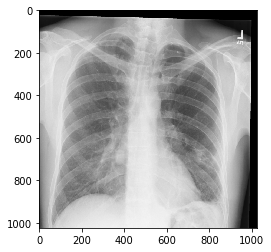

In [201]:
effusion_path = os.path.join(DATASET_PATH, disease_cls[0], '*')
effusion = glob.glob(effusion_path)
effusion = io.imread(effusion[-5]) # pick image which is not 
plt.imshow(effusion,cmap='gray')

In [202]:
img = preprocess_img(effusion[:,:,np.newaxis], 'val')

In [203]:
val_model.predict(img[np.newaxis,:])

array([[0.52707136, 0.47292873]], dtype=float32)

#### Looking at above result it is clear that model is predicting image correctly as we can see image is classified as effusion

## Comparing Models Accuracies

In [212]:
model_name="resnet_34"
model = ResnetBuilder.build_resnet_34((img_channels, img_rows, img_cols), nb_classes)
model.compile(loss=ncce,optimizer= sgd,metrics=metrics)

filepath = 'models/{}.hdf5'.format(model_name)
checkpoint = ModelCheckpoint(filepath, monitor='val_auc', verbose=1, save_best_only=True, mode='max')

logger = getLogger(model_name)

model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    epochs=20, 
                    callbacks=[auc_logger, decay, checkpoint , logger])

Epoch 1/20
13/13 [==============================] - 179s 14s/step - loss: 2.6549 - acc: 0.4351 - val_loss: 2.5699 - val_acc: 0.7812

Val AUC for epoch0: 0.7433155080213905

Epoch 00001: val_auc improved from -inf to 0.74332, saving model to models/resnet_34.hdf5
Epoch 2/20
13/13 [==============================] - 142s 11s/step - loss: 2.6043 - acc: 0.4781 - val_loss: 2.7113 - val_acc: 0.8854

Val AUC for epoch1: 0.6551724137931034

Epoch 00002: val_auc did not improve from 0.74332
Epoch 3/20
13/13 [==============================] - 158s 12s/step - loss: 2.4645 - acc: 0.7532 - val_loss: 2.5809 - val_acc: 0.3125

Val AUC for epoch2: 0.7

Epoch 00003: val_auc did not improve from 0.74332
Epoch 4/20
13/13 [==============================] - 159s 12s/step - loss: 2.3995 - acc: 0.5339 - val_loss: 2.5005 - val_acc: 0.6979

Val AUC for epoch3: 0.7593582887700536

Epoch 00004: val_auc improved from 0.74332 to 0.75936, saving model to models/resnet_34.hdf5
Epoch 5/20
13/13 [======================

In [213]:
model_name="resnet_50"
model = ResnetBuilder.build_resnet_50((img_channels, img_rows, img_cols), nb_classes)
model.compile(loss=ncce,optimizer= sgd,metrics=metrics)

filepath = 'models/{}.hdf5'.format(model_name)
checkpoint = ModelCheckpoint(filepath, monitor='val_auc', verbose=1, save_best_only=True, mode='max')

logger = getLogger(model_name)

model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    epochs=20, 
                    callbacks=[auc_logger, decay, checkpoint , logger])

Epoch 1/20
13/13 [==============================] - 320s 25s/step - loss: 6.0617 - acc: 0.4837 - val_loss: 8.3224 - val_acc: 0.1146

Val AUC for epoch0: 0.6641123882503193

Epoch 00001: val_auc improved from -inf to 0.66411, saving model to models/resnet_50.hdf5
Epoch 2/20
13/13 [==============================] - 277s 21s/step - loss: 5.9175 - acc: 0.5326 - val_loss: 6.0373 - val_acc: 0.9062

Val AUC for epoch1: 0.6395348837209303

Epoch 00002: val_auc did not improve from 0.66411
Epoch 3/20
13/13 [==============================] - 287s 22s/step - loss: 5.8200 - acc: 0.6075 - val_loss: 5.8948 - val_acc: 0.8854

Val AUC for epoch2: 0.7049808429118773

Epoch 00003: val_auc improved from 0.66411 to 0.70498, saving model to models/resnet_50.hdf5
Epoch 4/20
13/13 [==============================] - 284s 22s/step - loss: 5.1817 - acc: 0.6637 - val_loss: 5.4885 - val_acc: 0.9062

Val AUC for epoch3: 0.6590038314176245

Epoch 00004: val_auc did not improve from 0.70498
Epoch 5/20
13/13 [=======

In [214]:
model_name="resnet_101"
model = ResnetBuilder.build_resnet_101((img_channels, img_rows, img_cols), nb_classes)
model.compile(loss=ncce,optimizer= sgd,metrics=metrics)

filepath = 'models/{}.hdf5'.format(model_name)
checkpoint = ModelCheckpoint(filepath, monitor='val_auc', verbose=1, save_best_only=True, mode='max')

logger = getLogger(model_name)

model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    epochs=20, 
                    callbacks=[auc_logger, decay, checkpoint , logger])

Epoch 1/20
13/13 [==============================] - 557s 43s/step - loss: 10.0493 - acc: 0.5297 - val_loss: 14.3358 - val_acc: 0.9062

Val AUC for epoch0: 0.6203208556149733

Epoch 00001: val_auc improved from -inf to 0.62032, saving model to models/resnet_101.hdf5
Epoch 2/20
13/13 [==============================] - 358s 28s/step - loss: 10.2563 - acc: 0.5493 - val_loss: 11.9227 - val_acc: 0.8854

Val AUC for epoch1: 0.7372093023255815

Epoch 00002: val_auc improved from 0.62032 to 0.73721, saving model to models/resnet_101.hdf5
Epoch 3/20
13/13 [==============================] - 394s 30s/step - loss: 9.4330 - acc: 0.6049 - val_loss: 9.4147 - val_acc: 0.8750

Val AUC for epoch2: 0.822093023255814

Epoch 00003: val_auc improved from 0.73721 to 0.82209, saving model to models/resnet_101.hdf5
Epoch 4/20
13/13 [==============================] - 371s 29s/step - loss: 9.2638 - acc: 0.6921 - val_loss: 9.2871 - val_acc: 0.8438

Val AUC for epoch3: 0.7604651162790697

Epoch 00004: val_auc did n

In [215]:
model_name="resnet_152"
model = ResnetBuilder.build_resnet_152((img_channels, img_rows, img_cols), nb_classes)
model.compile(loss=ncce,optimizer= sgd,metrics=metrics)

filepath = 'models/{}.hdf5'.format(model_name)
checkpoint = ModelCheckpoint(filepath, monitor='val_auc', verbose=1, save_best_only=True, mode='max')

logger = getLogger(model_name)

model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    epochs=20, 
                    callbacks=[auc_logger, decay, checkpoint , logger])

Epoch 1/20
13/13 [==============================] - 665s 51s/step - loss: 13.4896 - acc: 0.5844 - val_loss: 12.9434 - val_acc: 0.5833

Val AUC for epoch0: 0.5616279069767443

Epoch 00001: val_auc improved from -inf to 0.56163, saving model to models/resnet_152.hdf5
Epoch 2/20
13/13 [==============================] - 641s 49s/step - loss: 14.4549 - acc: 0.4422 - val_loss: 13.4229 - val_acc: 0.7708

Val AUC for epoch1: 0.5614973262032086

Epoch 00002: val_auc did not improve from 0.56163
Epoch 3/20
13/13 [==============================] - 770s 59s/step - loss: 13.0909 - acc: 0.6035 - val_loss: 13.3095 - val_acc: 0.8854

Val AUC for epoch2: 0.706951871657754

Epoch 00003: val_auc improved from 0.56163 to 0.70695, saving model to models/resnet_152.hdf5
Epoch 4/20
13/13 [==============================] - 784s 60s/step - loss: 12.8813 - acc: 0.7015 - val_loss: 13.0217 - val_acc: 0.7292

Val AUC for epoch3: 0.6221590909090908

Epoch 00004: val_auc did not improve from 0.70695
Epoch 5/20
13/13

#### Accuracies Comparisions

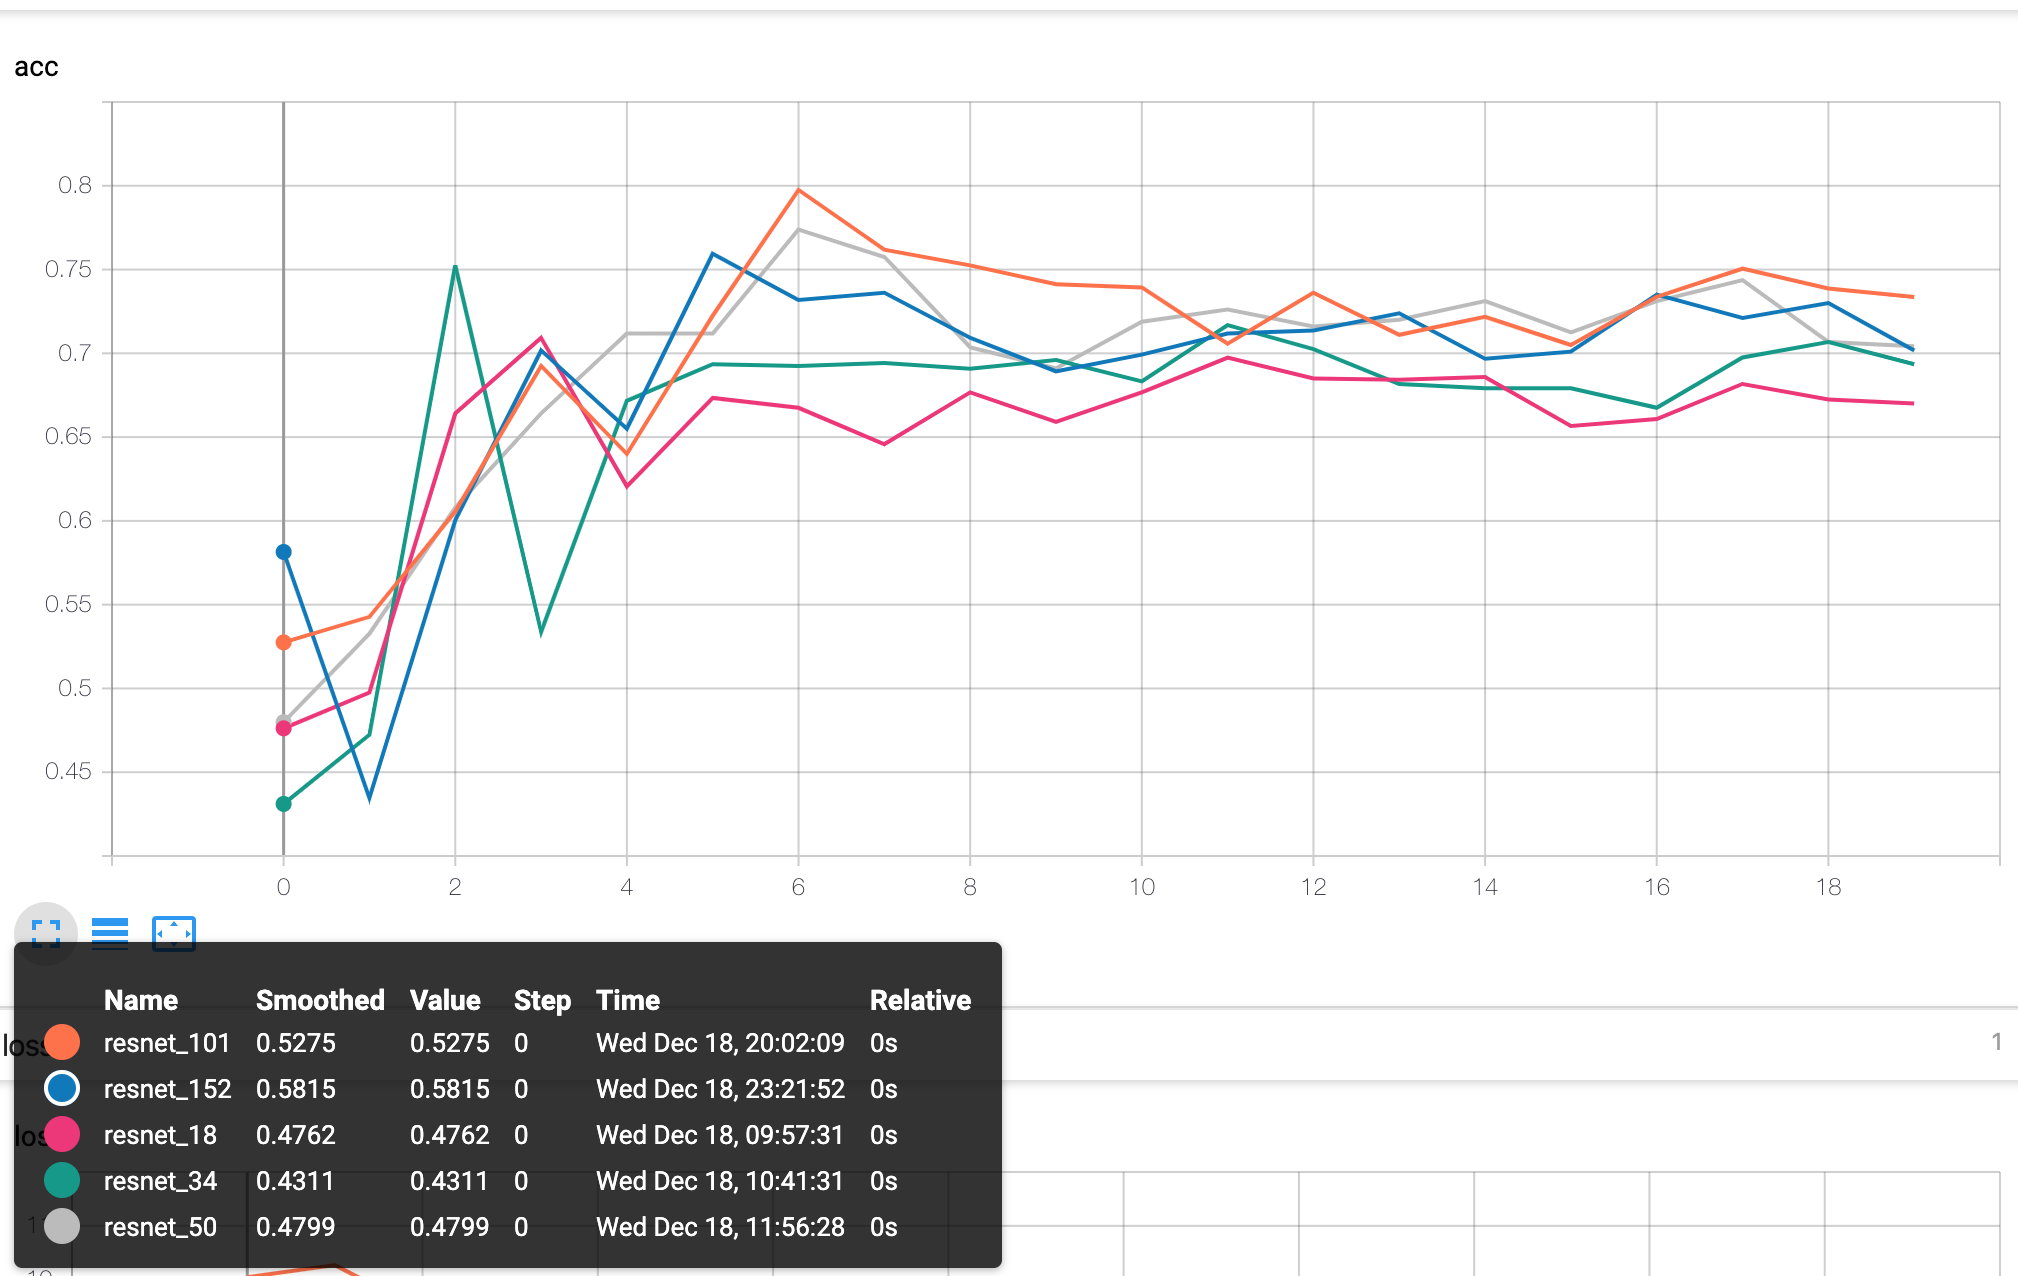

#### Validation Accuracies

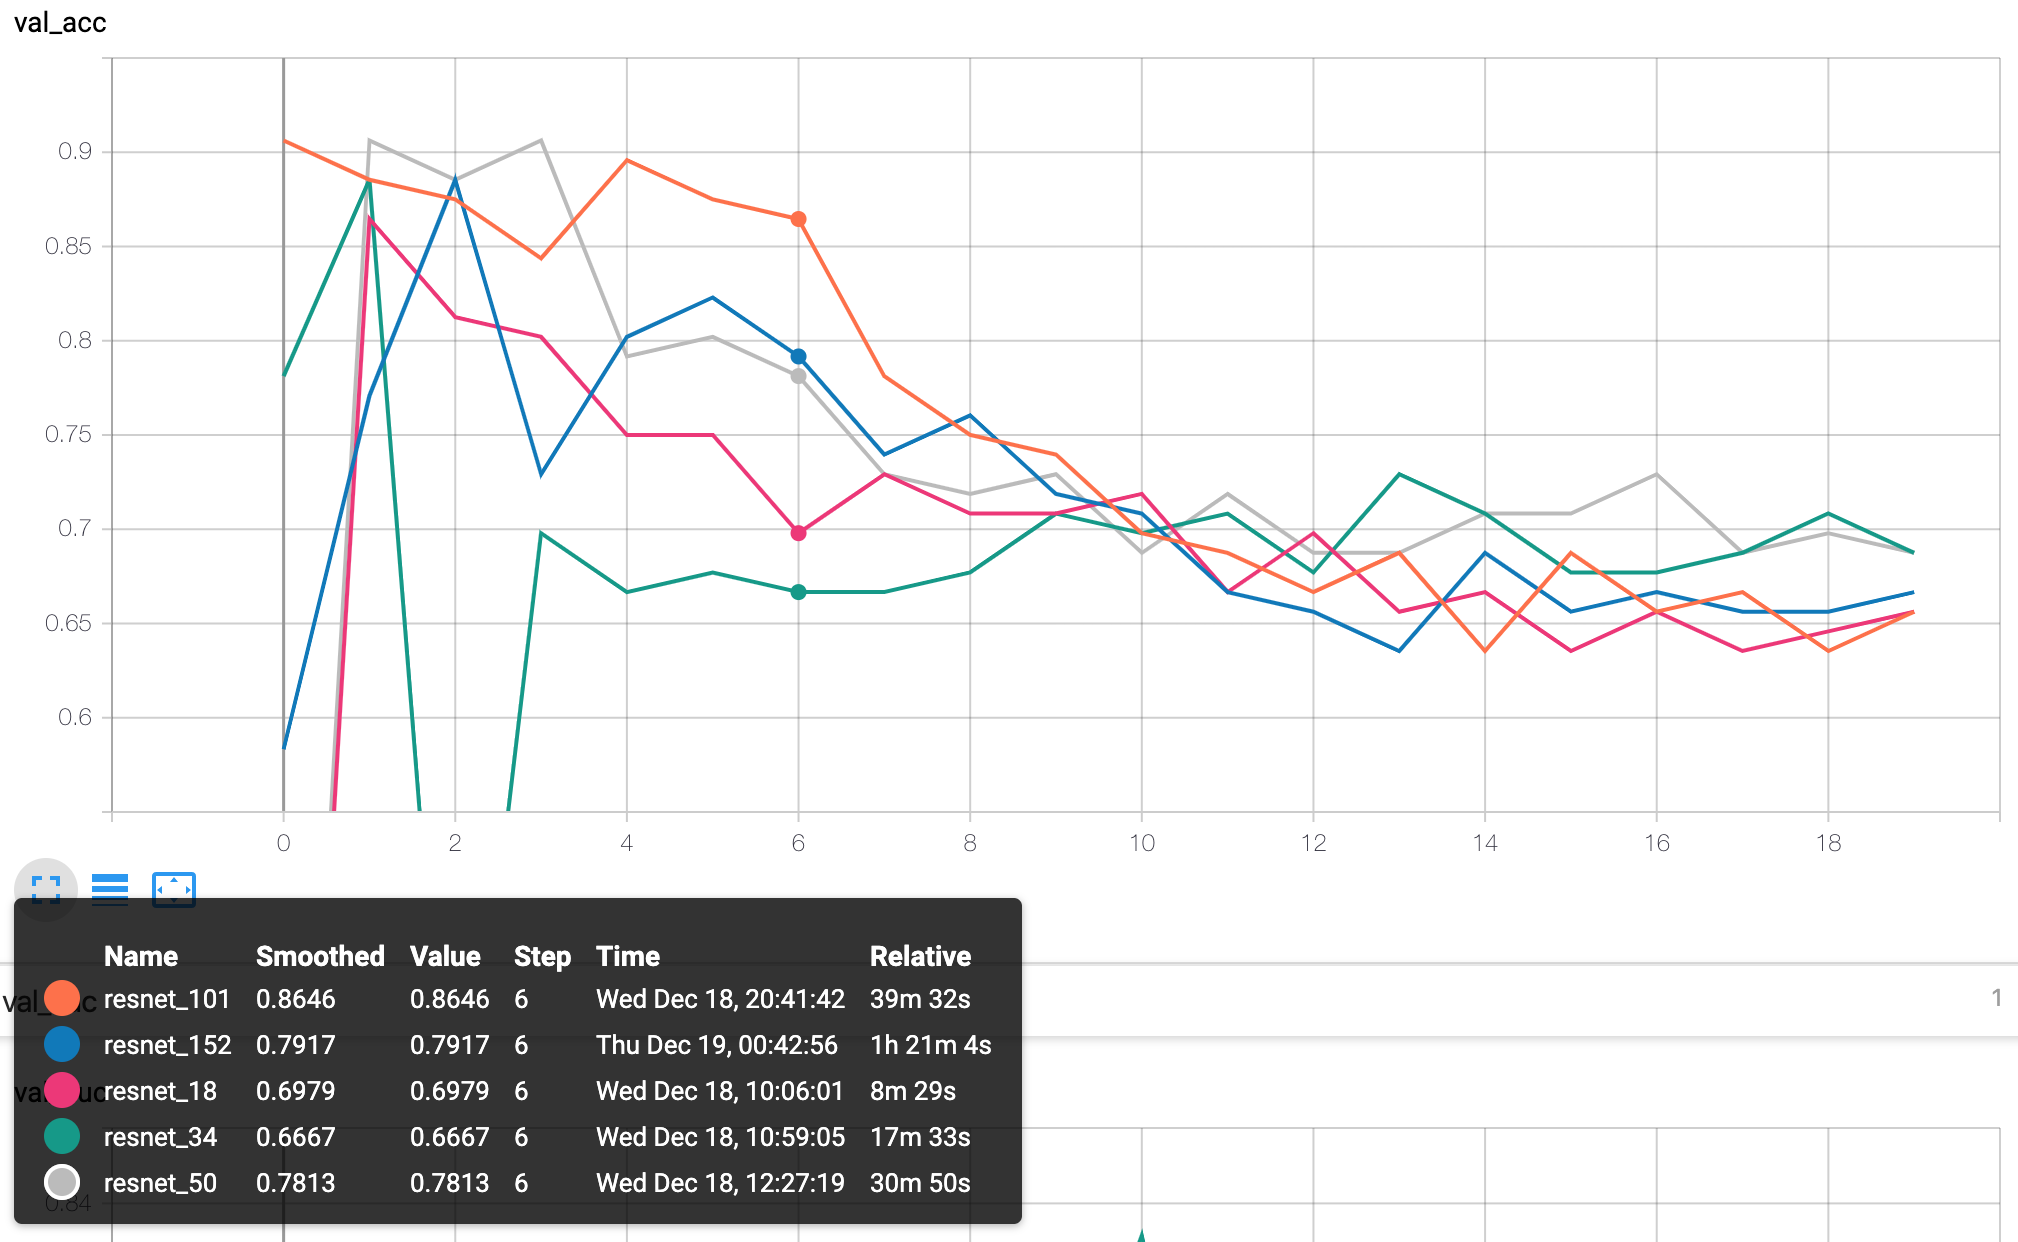

#### AUC Comparision

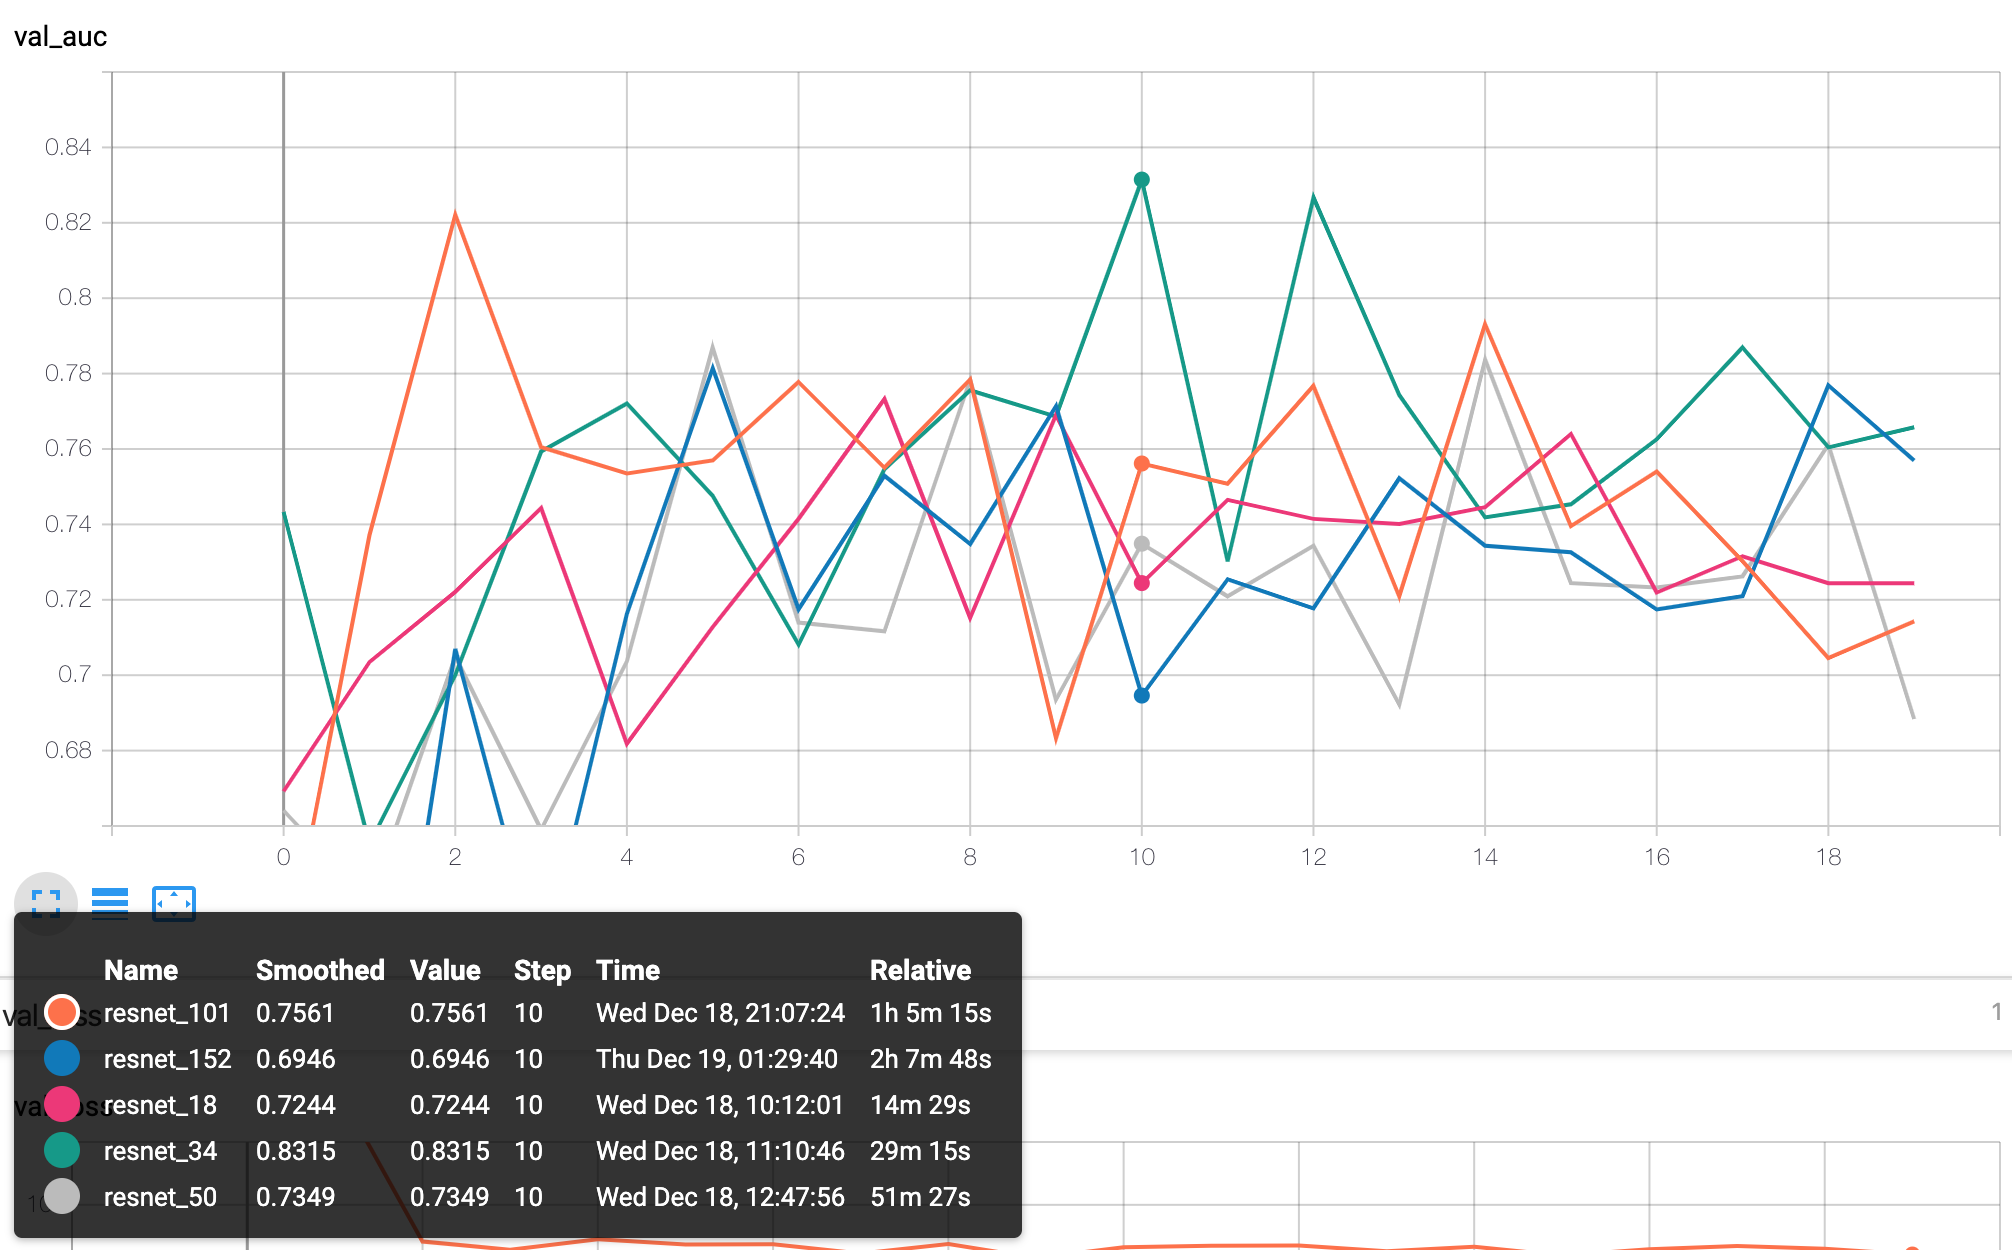

### Predicting Image using Models

In [217]:
print(disease_cls[0],"/",disease_cls[1])

effusion / nofinding


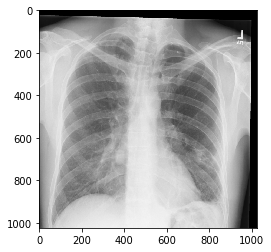

In [218]:
effusion_path = os.path.join(DATASET_PATH, disease_cls[0], '*')
effusion = glob.glob(effusion_path)
effusion = io.imread(effusion[-5]) # pick image from effusion which is not included during training 
plt.imshow(effusion,cmap='gray')

In [ ]:
img = preprocess_img(effusion[:,:,np.newaxis], 'val')

In [224]:
resnet_18 = ResnetBuilder.build_resnet_18((img_channels, img_rows, img_cols), nb_classes)
resnet_18.load_weights('models/resnet_18.hdf5')
resnet_18.predict(img[np.newaxis,:])

array([[0.44812536, 0.55187464]], dtype=float32)

In [221]:
resnet_34 = ResnetBuilder.build_resnet_34((img_channels, img_rows, img_cols), nb_classes)
resnet_34.load_weights('models/resnet_34.hdf5')
resnet_34.predict(img[np.newaxis,:])

array([[0.5149172 , 0.48508275]], dtype=float32)

In [222]:
resnet_50 = ResnetBuilder.build_resnet_50((img_channels, img_rows, img_cols), nb_classes)
resnet_50.load_weights('models/resnet_50.hdf5')
resnet_50.predict(img[np.newaxis,:])

array([[0.6442763 , 0.35572365]], dtype=float32)

In [225]:
resnet_101 = ResnetBuilder.build_resnet_101((img_channels, img_rows, img_cols), nb_classes)
resnet_101.load_weights('models/resnet_101.hdf5')
resnet_101.predict(img[np.newaxis,:])

array([[0.6184886 , 0.38151136]], dtype=float32)

In [226]:
resnet_152 = ResnetBuilder.build_resnet_152((img_channels, img_rows, img_cols), nb_classes)
resnet_152.load_weights('models/resnet_152.hdf5')
resnet_152.predict(img[np.newaxis,:])

array([[0.5269806 , 0.47301933]], dtype=float32)

#### By looking at above predictions we see that as the model gets complex in terms of weights and computation , predictoins are getting closer to actual values. It means that models with higer weights are predicting the class correctly and more efficiently.